# FINM 250 Homework 2
### TA Solutions

**Note:** in this notebook, pay close attention to how virtually all of my code is functionalized. This is a good habit to get into, and will save you a lot of time on the midterm. By having a lot of different functions, I'm able to complete the entire assignment with (excluding multi-line statements for formatting purposes) 25 lines of code *total*. If I further exclude plotting/displaying code to make the answers look nice, the "core" code is only 12-15 lines long.

## Part 2

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Pandas settings.
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

# Constants for risk metrics, return metrics, and annualization.
RETURN_COLS = ["Annualized Return", "Annualized Volatility", "Annualized Sharpe Ratio"]
RISK_COLS = [
    "Skewness",
    "Excess Kurtosis",
    "VaR (0.05)",
    "CVaR (0.05)",
    "Max Drawdown",
    "Bottom",
    "Peak",
    "Recovery",
    "Duration (days)",
]
ADJ = 12


def calc_return_metrics(data, as_df=False, adj=12):
    """
    Calculate return metrics for a given dataset. Specifically:
    - Annualized Return
    - Annualized Volatility
    - Annualized Sharpe Ratio
    - Annualized Sortino Ratio (not part of the course, but useful to know)

    Args:
        data : Returns time series.
        as_df (bool, optional): Return a df or dict. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame or dict: Summary of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = (
        summary["Annualized Return"] * np.sqrt(adj) / (data[data < 0].std())
    )

    # Here, we use what is known as a "ternary operator", usually denoted as "condition ? if_true : if_false",
    # in other programming languages. This is equivalent to having an explicit if-else statement, but is more
    # concise and can be written on a single line.
    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_risk_metrics(data, as_df=False, adj=12):
    """
    Calculate risk metrics for a given dataset. Specifically:
    - Skewness
    - Kurt
    - VaR (0.05)
    - CVaR (0.05)
    - Max Return in a single period
    - Min Return in a single period
    - Peak
    - Max Drawdown
    - Bottom (of drawdown)
    - Recovery (of drawdown)

    Args:
        data : Returns time series.
        as_df (bool, optional): Return a df or a dictionary. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame or Dictionary: Summary of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05, axis=0)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    # Cumulative returns on $1000
    wealth_index = 1000 * (1 + data).cumprod()

    previous_peaks = wealth_index.cummax()

    # Biggest difference between cumulative max and your current wealth
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Peak"] = previous_peaks.idxmax()
    summary["Bottom"] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )

    # Here, we use a list comprehension to check if the recovery date is null,
    # meaning that the drawdown has not yet recovered.
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    # Note that here we use the zip() function to iterator over two lists at the same time.
    # This is equivalent to using a for loop over the indices of the lists, and then getting
    # the values at those indices.
    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_perf_metrics(data, adj=12):
    """
    Calculate performance metrics for a given dataset.

    Args:
        data : Returns time series.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame: Summary of performance metrics.
    """
    # This is a more advanced Python concept, known as "dictionary unpacking".
    # It is equivalent to joining the two dictionaries together using a for loop
    # over the keys, but is much more concise.

    # There is a similar concept for lists, known as "list unpacking" or "iterator unpacking",
    # as it works for any iterable object. We use this via tha *list operator. So, if we
    # wanted to join two lists together, we would do: list3 = [*list1, *list2].

    summary = {**calc_return_metrics(data, adj), **calc_risk_metrics(data, adj)}
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)


def calc_univ_regr(y, X, intercept=True, adj=12):
    """
    Calculate a univariate regression of y on X. Note that both X and y
    need to be one-dimensional.

    Args:
        y : target variable
        X : independent variable
        intercept (bool, optional): Fit the regression with an intercept or not. Defaults to True.
        adj (int, optional): What to adjust the returns by. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    X_down = X[X < 0]
    y_down = y[X < 0]
    if intercept:
        X = sm.add_constant(X)
        X_down = sm.add_constant(X_down)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()

    # More ternary operators.
    inter = results.params[0] if intercept else 0
    beta = results.params[1] if intercept else results.params[0]

    summary = dict()

    summary["Alpha"] = inter * adj
    summary["Beta"] = beta

    # Note: Downside Beta is not part of the course, but is a useful metric to know.
    down_mod = sm.OLS(y_down, X_down, missing="drop").fit()
    summary["Downside Beta"] = down_mod.params[1] if intercept else down_mod.params[0]

    summary["R-Squared"] = results.rsquared
    summary["Treynor Ratio"] = (y.mean() / beta) * adj
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )

    return pd.DataFrame(summary, index=[y.name])


def calc_multi_regr(y, X, intercept=True, adj=12):
    """
    Calculate a multivariate regression of y on X. Adds useful metrics such
    as the Information Ratio and Tracking Error. Note that we can't calculate
    Treynor Ratio or Downside Beta here.

    Args:
        y : target variable
        X : independent variables
        intercept (bool, optional): Defaults to True.
        adj (int, optional): Annualization factor. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    if intercept:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()
    summary = dict()

    inter = results.params[0] if intercept else 0
    betas = results.params[1:] if intercept else results.params

    summary["Alpha"] = inter * adj
    summary["R-Squared"] = results.rsquared

    X_cols = X.columns[1:] if intercept else X.columns

    for i, col in enumerate(X_cols):
        summary[f"{col} Beta"] = betas[i]

    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )
    return pd.DataFrame(summary, index=[y.name])


def calc_iter_regr(y, X, intercept=True, one_to_many=False, adj=12):
    """
    Iterative regression for checking one X column against many different y columns,
    or vice versa. "one_to_many=True" means that we are checking one X column against many
    y columns, and "one_to_many=False" means that we are checking many X columns against a
    single y column.

    Args:
        y : Target variable(s)
        X : Independent variable(s)
        intercept (bool, optional): Defaults to True.
        one_to_many (bool, optional): Which way to run the regression. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame : Summary of regression results.
    """
    if one_to_many:
        summary = pd.concat(
            [calc_univ_regr(y[col], X, intercept, adj) for col in y.columns], axis=0
        )
        summary.index = y.columns
        return summary
    else:
        summary = pd.concat(
            [calc_univ_regr(y, X[col], intercept, adj) for col in X.columns], axis=0
        )
        summary.index = X.columns
        return summary


def plot_corr_matrix(corrs):
    # Correlation helper function.
    return sns.heatmap(
        corrs,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        linewidths=0.7,
        annot_kws={"size": 10},
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": 0.75},
    )


def print_max_min_corr(corrs):
    # Correlation helper function.
    corr_series = corrs.unstack()
    corr_series = corr_series[corr_series != 1]

    max_corr = corr_series.abs().agg(["idxmax", "max"]).T
    min_corr = corr_series.abs().agg(["idxmin", "min"]).T
    min_corr_raw = corr_series.agg(["idxmin", "min"]).T
    max_corr, max_corr_val = max_corr["idxmax"], max_corr["max"]
    min_corr, min_corr_val = min_corr["idxmin"], min_corr["min"]
    min_corr_raw, min_corr_raw_val = min_corr_raw["idxmin"], min_corr_raw["min"]

    print(
        f"Max Corr (by absolute value): {max_corr[0]} and {max_corr[1]} with a correlation of {max_corr_val:.2f}"
    )
    print(
        f"Min Corr (by absolute value): {min_corr[0]} and {min_corr[1]} with a correlation of {min_corr_val:.2f}"
    )
    print(
        f"Min Corr (raw): {min_corr_raw[0]} and {min_corr_raw[1]} with a correlation of {min_corr_raw_val:.2f}"
    )


# Those who read through the "How to Avoid Typing the Same Variables Over and Over Again" section
# of TA Review number 2 (https://github.com/MarkHendricks/finm-quant-2024/blob/main/reviews/TA_Review_2.ipynb)
# which I skipped to save for later, may notice that this is a great place for a partial function.

# Load data.

from functools import partial

get_data = partial(
    pd.read_excel, "../data/proshares_analysis_data.xlsx", index_col=0, parse_dates=[0]
)

rets_hf = get_data(sheet_name="hedge_fund_series")
rets_ml = get_data(sheet_name="merrill_factors")
rets_other = get_data(sheet_name="other_data")

## 1

In [2]:
metrics = calc_perf_metrics(rets_hf)
metrics[RETURN_COLS]

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
HFRIFWI Index,0.0414,0.0604,0.6860
MLEIFCTR Index,0.0307,0.0571,0.5367
MLEIFCTX Index,0.0292,0.0570,0.5131
HDG US Equity,0.0194,0.0596,0.3263
QAI US Equity,0.0170,0.0499,0.3399


## 2

In [3]:
metrics[RISK_COLS]

,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Bottom,Peak,Recovery,Duration (days)
HFRIFWI Index,-0.9791,5.9551,-0.0253,-0.0375,-0.1155,2020-03-31,2021-10-31,2020-08-31 00:00:00,153
MLEIFCTR Index,-0.2450,1.6896,-0.0288,-0.0359,-0.1243,2022-09-30,2021-06-30,-,-
MLEIFCTX Index,-0.2310,1.6579,-0.0291,-0.0358,-0.1244,2022-09-30,2021-06-30,-,-
HDG US Equity,-0.2339,1.7991,-0.0312,-0.0376,-0.1407,2022-09-30,2021-06-30,-,-
QAI US Equity,-0.4613,1.8260,-0.0206,-0.0327,-0.1377,2022-09-30,2021-06-30,-,-


We note that all except HFRIFWI have not yet recovered from their maximum drawdowns.

## 3

In [4]:
spy = rets_ml["SPY US Equity"]
regression_metrics = calc_iter_regr(rets_hf, spy, one_to_many=True)
regression_metrics

,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
HFRIFWI Index,-0.0036,0.3482,0.4074,0.7107,0.1190,-0.1095,0.0027
MLEIFCTR Index,-0.0145,0.3499,0.3894,0.8018,0.0877,-0.5719,0.0021
MLEIFCTX Index,-0.0158,0.3485,0.3856,0.8002,0.0839,-0.6205,0.0021
HDG US Equity,-0.0270,0.3595,0.4070,0.7788,0.0541,-0.9644,0.0023
QAI US Equity,-0.0211,0.2941,0.2891,0.7433,0.0577,-0.8327,0.0021


## 4
### 4.a

In [5]:
metrics_spy = pd.concat([metrics, calc_perf_metrics(spy.to_frame("SPY"))], axis=0)
metrics_spy[RETURN_COLS + RISK_COLS]

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Bottom,Peak,Recovery,Duration (days)
HFRIFWI Index,0.0414,0.0604,0.6860,-0.9791,5.9551,-0.0253,-0.0375,-0.1155,2020-03-31,2021-10-31,2020-08-31 00:00:00,153
MLEIFCTR Index,0.0307,0.0571,0.5367,-0.2450,1.6896,-0.0288,-0.0359,-0.1243,2022-09-30,2021-06-30,-,-
MLEIFCTX Index,0.0292,0.0570,0.5131,-0.2310,1.6579,-0.0291,-0.0358,-0.1244,2022-09-30,2021-06-30,-,-
HDG US Equity,0.0194,0.0596,0.3263,-0.2339,1.7991,-0.0312,-0.0376,-0.1407,2022-09-30,2021-06-30,-,-
QAI US Equity,0.0170,0.0499,0.3399,-0.4613,1.8260,-0.0206,-0.0327,-0.1377,2022-09-30,2021-06-30,-,-
SPY,0.1292,0.1463,0.8837,-0.4054,0.7967,-0.0688,-0.0866,-0.2393,2022-09-30,2021-12-31,-,-


I would argue that it depends on the investors risk preference. Namely, SPY has better risk adjusted returns (higher Sharpe) than all members of the hedge fund series. It also has better kurtosis, with an excess of kurtosis of 0.8 compared to between 1.65 and 5.95 for the hedge fund series. It's mean is also much larger, and is between 3 and 10 times larger than the hedge fund series.

However, when looking at other metrics, such as VaR, the hedge fund series has both a lower VaR and CVaR than SPY. We can further confirm this tail-risk that SPY has by looking at the Max Drawdown, which is 24% for SPY, compared with 11-14% for the hedge fund series. So, it would seem that SPY performs better when looking at mean and variance, but worse when looking at measures of tail risk.

Another point is that the hedge fund series is highly correlated with SPY, with correlations between 0.7 and 0.8. This indicates that most of the variance of the hedge funds can be explained by SPY, and so the hedge funds are perhaps not providing much diversification. All of the hedge funds have negative alpha (meaning that they fail to beat the market). Though, their betas are not *too* extreme, and their downside betas are actually lower than their betas, indicating that they are not as exposed to downside risk as SPY -- so they are providing some "hedge" against downside risk.

### 4.b

In [6]:
# Get HDG US Equity and QAI US Equity, and concat both their regression_metrics and metrics
pd.concat(
    [
        metrics.T[["HDG US Equity", "QAI US Equity"]],
        regression_metrics.T[["HDG US Equity", "QAI US Equity"]],
    ],
    axis=0,
)

,HDG US Equity,QAI US Equity
Annualized Return,0.0194,0.0170
Annualized Volatility,0.0596,0.0499
Annualized Sharpe Ratio,0.3263,0.3399
Annualized Sortino Ratio,5.1304,5.5913
Skewness,-0.2339,-0.4613
Excess Kurtosis,1.7991,1.8260
VaR (0.05),-0.0312,-0.0206
CVaR (0.05),-0.0376,-0.0327
Min,-0.0592,-0.0563
Max,0.0583,0.0398


QAI performs marginally better when looking at market correlation, but they are basically the same. Both have very similar Sharpe ratios, although QAI has lower vol, and HDG has a higher mean. Both have negative skew and an excess kurtosis of around 1.8 (although QAI has higher skew). Both have similar VaR and CVaR, although QAI performs better on both (slightly).

However, where I think the argument is stronger for QAI is when looking at the correlation with SPY. It has a $r^2$ of 0.74, compared to HDG's 0.78. Moreover, the market beta for QAI is smaller, at around 0.29, compared with HDG's 0.36. It also has a slightly larger alpha, meaning that less of it's returns can be explained by the market. It has a lower downside beta, indicating it is less exposed to downside risk than HDG.

Though I would argue they are very similar, and unsurprisingly are 88% correlated with each other.

In [7]:
rets_hf[["HDG US Equity", "QAI US Equity"]].corr()

,HDG US Equity,QAI US Equity
HDG US Equity,1.0000,0.8767
QAI US Equity,0.8767,1.0000


### 4.c

I would say yes; all have very similar risk metrics, returns, Sharpe ratio's, etc. HFRI has slightly better returns and a higher Sharpe. The biggest difference is in skew/kurt: HFRI has much higher kurtosis than both the ML series and HDG, with an excess kurtosis of around 6, compared to 1.7-1.8 for the others. It also has much bigger skew, at around -0.97, compared with -0.23-0.24 for the others. 

So, I would say that HFRI has bigger tails and more skew than the others, but HDG and the ML series capture most of it's properties. From Question 5, we see that the ML series is 90% correlated with HFRI, and HDG is 88% correlated with HFRI.

We can further confirm this via regression.

**Note** due to extremely high multicollinearity we probably do not want to run a regression with our $X$ inputs being these 3 factors, so we will run 3 separate regressions, one for each factor.

In [8]:
display(
    calc_univ_regr(
        rets_hf["HFRIFWI Index"], rets_hf["HDG US Equity"], intercept=True
    ).rename({"Beta": "HDG Beta"}, axis=1)
)

display(
    calc_univ_regr(
        rets_hf["HFRIFWI Index"], rets_hf["MLEIFCTR Index"], intercept=True
    ).rename({"Beta": "ML Factor 1 Beta"}, axis=1)
)

display(
    calc_univ_regr(
        rets_hf["HFRIFWI Index"], rets_hf["MLEIFCTX Index"], intercept=True
    ).rename({"Beta": "ML Factor 2 Beta"}, axis=1)
)

,Alpha,HDG Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
HFRIFWI Index,0.0240,0.8970,1.0751,0.7827,0.0462,0.8524,0.0023


,Alpha,ML Factor 1 Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
HFRIFWI Index,0.0124,0.9470,1.0717,0.8023,0.0438,0.4618,0.0022


,Alpha,ML Factor 2 Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
HFRIFWI Index,0.0137,0.9490,1.0779,0.8012,0.0437,0.5085,0.0022


The R-squared values are all very high, betas are close to 1. Thus, it does seem that the ML series and HDG capture most of the properties of HFRI.

## 5

### 5.a

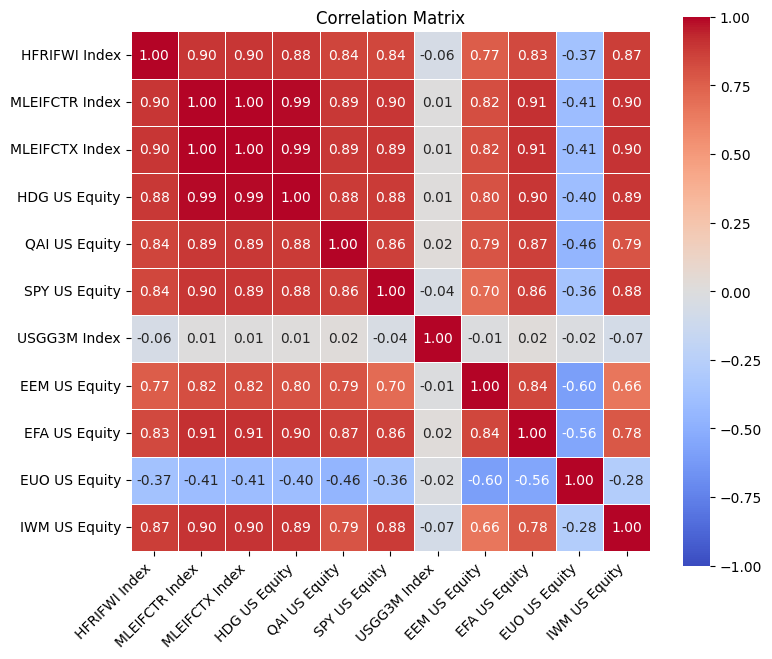

In [9]:
corr_matrix = pd.concat([rets_hf, rets_ml], axis=1).corr()

fig, _ = plt.subplots(figsize=(8, 8))
ax = plot_corr_matrix(corr_matrix)

ax.set_title("Correlation Matrix")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

fig.tight_layout()

### 5.b

In [10]:
print_max_min_corr(corr_matrix)

Max Corr (by absolute value): MLEIFCTR Index and MLEIFCTX Index with a correlation of 1.00
Min Corr (by absolute value): MLEIFCTX Index and USGG3M Index with a correlation of 0.01
Min Corr (raw): EEM US Equity and EUO US Equity with a correlation of -0.60


## 6

In [11]:
replication = pd.concat(
    [
        calc_multi_regr(rets_hf["HFRIFWI Index"], rets_ml).T,
        calc_multi_regr(rets_hf["HFRIFWI Index"], rets_ml, intercept=False).T,
    ],
    axis=1,
)

replication.columns = ["HFRI (Intercept)", "HFRI (No Intercept)"]
replication

,HFRI (Intercept),HFRI (No Intercept)
Alpha,0.0178,0.0000
R-Squared,0.8361,0.8380
SPY US Equity Beta,0.0300,0.0490
USGG3M Index Beta,-0.3709,0.2457
EEM US Equity Beta,0.0791,0.0790
EFA US Equity Beta,0.0842,0.0752
EUO US Equity Beta,0.0231,0.0259
IWM US Equity Beta,0.1533,0.1501
Information Ratio,0.7274,0.0000
Tracking Error,0.0020,0.0246


We are able to replicate 83.6% of the variance of the returns of HFRI using the Merrill Lynch factors. We have an intercept of 0.0178 (annualized), or 0.0015 non-annualized.

We also have quite reasonable betas, with the largest being 15% of our portfolio, and the smallest being -37% of our portfolio. This indicates that we are not overly exposed to one factor. However, the -37% in 3-month T-bills is a little bit concerning, as the interpretation of this beta is that we are shorting a lot of T-bills (borrowing money) to invest in the other factors. But, -37% is not too much leverage (and is well within the range of a hedge fund - and would be considered very low leverage for a T-bill position). So, I would say that this is not too concerning.

Overall, the replication works quite well.

## Extras

## 1

OOS-R-Squared: 80.86%


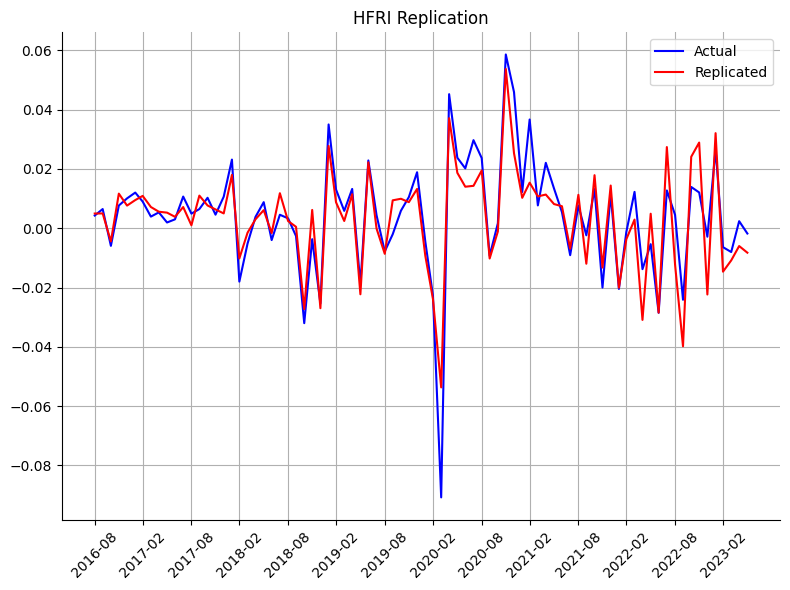

In [12]:
# Here, we use a new Python concept, called a defaultdict. This is a dictionary that
# automatically creates a new key if it doesn't exist. We can pass it a type in the constructor,
# and it will create a new key with that type if it doesn't exist and then we can interact with
# it as if it were a normal dictionary. So, since we have a list, we can do summary[key].append(value),
# without having to first do summary[key] = [].
from collections import defaultdict

summary = defaultdict(list)


for idx in range(60, len(rets_hf), 1):
    # Get the data for ML factors and HFRI
    X = rets_ml.iloc[idx - 60 : idx].copy()
    y = rets_hf.iloc[idx - 60 : idx, 0].copy()

    oos_y = rets_hf.iloc[idx, 0]
    oos_X = rets_ml.iloc[idx, :].copy()

    # Calculate the regression coefficients
    regr = sm.OLS(y, sm.add_constant(X), missing="drop").fit()

    for jdx, coeff in enumerate(regr.params.index):
        summary[coeff].append(regr.params[jdx])

    # Get predicted y by multiplying the coefficients by the X values and
    # adding the intercept
    y_pred = regr.params[0] + (regr.params[1:] @ oos_X)

    summary["Replicated"].append(y_pred)
    summary["Actual"].append(oos_y)


summary = pd.DataFrame(summary, index=rets_hf.index[60:])

# Calculate OOS R-Squared
oos_rsquared = (
    1 - (summary["Actual"] - summary["Replicated"]).var() / summary["Actual"].var()
)
print(f"OOS-R-Squared: {oos_rsquared:.2%}")

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(summary.index, summary["Actual"], label="Actual", color="blue")
ax.plot(summary.index, summary["Replicated"], label="Replicated", color="red")
ax.grid(True)
ax.legend()

# Make ticklabels every 6 months and label them as %yyy-%mm
ax.set_xticks(summary.index[::6])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in summary.index[::6]],
    rotation=45,
    horizontalalignment="center",
)

ax.set_title("HFRI Replication")
fig.tight_layout()

It does an extremely good job of replicating, with an out-of-sample R-squared of 80%!

## 2

I already did this in 6, but:

In [13]:
replication

,HFRI (Intercept),HFRI (No Intercept)
Alpha,0.0178,0.0000
R-Squared,0.8361,0.8380
SPY US Equity Beta,0.0300,0.0490
USGG3M Index Beta,-0.3709,0.2457
EEM US Equity Beta,0.0791,0.0790
EFA US Equity Beta,0.0842,0.0752
EUO US Equity Beta,0.0231,0.0259
IWM US Equity Beta,0.1533,0.1501
Information Ratio,0.7274,0.0000
Tracking Error,0.0020,0.0246


It does better than with an intercept. Additionally, all of the betas are positive, and of much more reasonable sizes. Although, the tracking error is about 10x bigger, and of course we no longer have alpha or an information ratio.

## 3.a

NNLS R-Squared: 83.56%


,Weights
const,0.0012
SPY US Equity,0.0307
USGG3M Index,0.0000
EEM US Equity,0.0796
EFA US Equity,0.0814
EUO US Equity,0.0228
IWM US Equity,0.1547


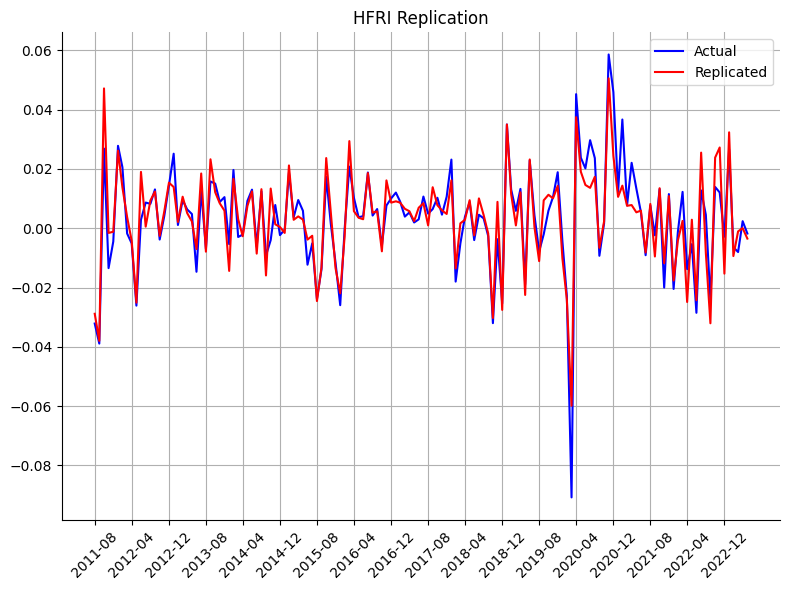

In [14]:
# Use non-negative least squares to get the weights
from sklearn.linear_model import LinearRegression

hfri = rets_hf["HFRIFWI Index"]

non_neg = LinearRegression(fit_intercept=True, positive=True).fit(rets_ml, hfri)

non_neg_r2 = non_neg.score(rets_ml, hfri)
print(f"NNLS R-Squared: {non_neg_r2:.2%}")

# Display the weights
weights = pd.DataFrame(
    [non_neg.intercept_, *non_neg.coef_],
    index=["const", *rets_ml.columns],
    columns=["Weights"],
)
display(weights)

# Plot the replication
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(hfri.index, hfri, label="Actual", color="blue")
ax.plot(hfri.index, non_neg.predict(rets_ml), label="Replicated", color="red")
ax.legend()
ax.grid(True)
ax.set_title("HFRI Replication")
ax.set_xticks(hfri.index[::8])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in hfri.index[::8]],
    rotation=45,
    horizontalalignment="center",
)
fig.tight_layout()

## 3.b

GLM R-Squared: 75.94%


,Weights
const,0.0010
SPY US Equity,0.0500
USGG3M Index,0.1000
EEM US Equity,0.0806
EFA US Equity,0.0709
EUO US Equity,0.0218
IWM US Equity,0.1477


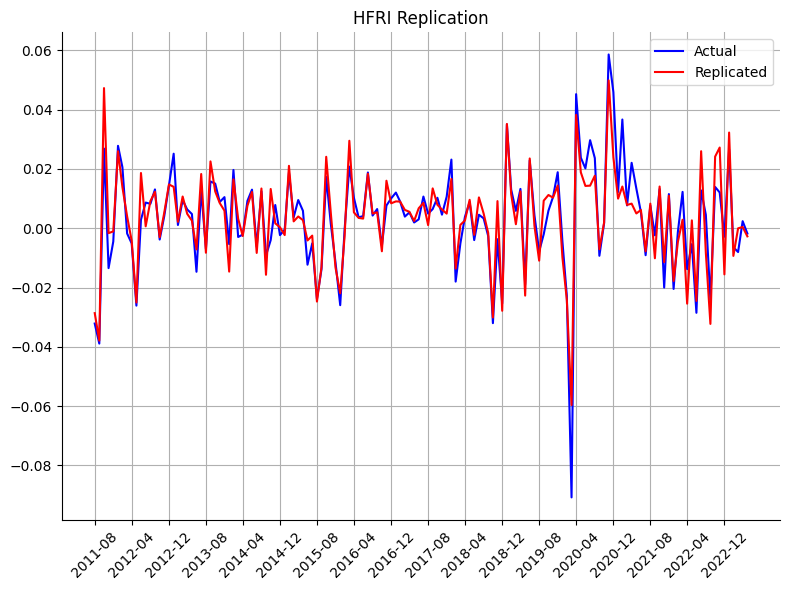

In [15]:
# Use GLM to get the weights, suppose we cap the USGG3M at 0.1 and SPY at 0.05
glm_weights = sm.GLM(
    hfri, sm.add_constant(rets_ml), family=sm.families.Gaussian()
).fit_constrained(["USGG3M Index = 0.1", "SPY US Equity = 0.05"])

# Calculate R-2

# This is from: https://stackoverflow.com/questions/26541899/why-doesnt-statsmodels-glm-have-r2-in-results
sst_val = sum(map(lambda x: np.power(x, 2), y - np.mean(y)))
sse_val = sum(map(lambda x: np.power(x, 2), glm_weights.resid_response))
r2 = 1.0 - sse_val / sst_val

print(f"GLM R-Squared: {r2:.2%}")

# Display the weights
display(pd.DataFrame(glm_weights.params, columns=["Weights"]))

# Plot the replication
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(hfri.index, hfri, label="Actual", color="blue")
ax.plot(
    hfri.index,
    glm_weights.predict(sm.add_constant(rets_ml)),
    label="Replicated",
    color="red",
)
ax.legend()
ax.grid(True)
ax.set_xticks(hfri.index[::8])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in hfri.index[::8]],
    rotation=45,
    horizontalalignment="center",
)
ax.set_title("HFRI Replication")
fig.tight_layout()

## 4.a

In [16]:
calc_multi_regr(rets_other["HEFA US Equity"], rets_ml, intercept=True).T

,HEFA US Equity
Alpha,0.0145
R-Squared,0.9700
SPY US Equity Beta,0.0051
USGG3M Index Beta,0.0258
EEM US Equity Beta,-0.0719
EFA US Equity Beta,0.9526
EUO US Equity Beta,0.3224
IWM US Equity Beta,0.0269
Information Ratio,0.6560
Tracking Error,0.0018


Yes, it does look like a currency-hedged version of EFA. In particular, we have a beta of 0.95 on EFA, meaning that it tracks it quite well. Of course, it's hard to say how well the hedge performs without other data, but at least judging by this regression HEFA and EFA are closely related.

## 4.b

In [17]:
calc_multi_regr(rets_other["TRVCI Index"], rets_ml, intercept=True).T

,TRVCI Index
Alpha,-0.0196
R-Squared,0.7003
SPY US Equity Beta,1.8465
USGG3M Index Beta,1.8244
EEM US Equity Beta,-0.0853
EFA US Equity Beta,-0.0701
EUO US Equity Beta,-0.0582
IWM US Equity Beta,-0.1849
Information Ratio,-0.1349
Tracking Error,0.0121


High betas on SPY and USGG3M. However, a somewhat low R-squared of 0.7. I would argue (perhaps cynically) that this does describe venture capital somewhat well; lots of leverage (high beta on USGG3M) but returns that are no different than the market.

## 4.c

In [18]:
# Regress rets_other['TAIL US Equity'] on SPY. However, we make an adjustment: we add a "put like" factor to SPY.

rets_spy = rets_ml[["SPY US Equity"]].copy()
rets_spy["Put Factor"] = np.maximum(0, rets_spy["SPY US Equity"])

# Run the regression without the put factor
display(calc_multi_regr(rets_other["TAIL US Equity"], spy, intercept=True).T)

# And with
display(calc_multi_regr(rets_other["TAIL US Equity"], rets_spy, intercept=True).T)

,TAIL US Equity
Alpha,-0.0028
R-Squared,0.5985
SPY US Equity Beta,-0.5515
Information Ratio,-0.0359
Tracking Error,0.0065


,TAIL US Equity
Alpha,-0.0689
R-Squared,0.6117
SPY US Equity Beta,-0.6862
Put Factor Beta,0.2713
Information Ratio,-0.9047
Tracking Error,0.0063


It's hard to say. The correlation to SPY is quite low, but it does have a non-trivial beta on the "put like" factor. But overall I would say no.

## 5.a

Because they have to continually re-lever in order to track the index at 3x. This means that they have a decay over time and the expected return of holding these ETF to infinity is -100%. As an example:

- Day 1: SPY is at 100, and closes at 110 (10% up). The 3x ETF is at 100, and closes at 130 (30% up).
- Day 2: SPY is at 110, and closes at 100 (-9.1% down). The 3x ETF is at 130, and closes at 94.51 (-27.3% down).

So, even though SPY is back to where it started, the 3x ETF is down 5.49%. This is because it has to re-lever every day, and so it is buying high and selling low. For example, during the financial crisis when there were many large movements down, we would expect these ETFs to lose a lot of value due to continually having to re-lever. This is also why they have high management feed (UPRO has 0.91% management fee, compared to 0.09% for SPY, or 0.03% for VOO).

Pro Shares also wins the dubious award of most value lost by an ETF creator: https://twitter.com/quantian1/status/1600168896459251712?s=20 

## 5.b

In [19]:
# Note that if we maintained perfect 3x leverage, we would expect UPRO vs. SPY to have a beta of 3 on SPY.
# In fact, Pro-Shares even claims this on their website:
# 3x Short: https://www.proshares.com/globalassets/proshares/fact-sheet/prosharesfactsheetspxu.pdf
# 3x Long: https://www.proshares.com/globalassets/proshares/fact-sheet/prosharesfactsheetupro.pdf
upro_regr = calc_univ_regr(rets_other["UPRO US Equity"], spy, intercept=True).T
upro_regr

,UPRO US Equity
Alpha,-0.0706
Beta,3.0949
Downside Beta,3.1234
R-Squared,0.9927
Treynor Ratio,0.1064
Information Ratio,-1.8174
Tracking Error,0.0032


It does a remarkably good job of staying 3x levered.

In [20]:
# Same thing but for SPXU -- -3x leverage.
spxu_regr = calc_univ_regr(rets_other["SPXU US Equity"], spy, intercept=True).T
spxu_regr

,SPXU US Equity
Alpha,-0.0879
Beta,-2.6370
Downside Beta,-2.2654
R-Squared,0.9090
Treynor Ratio,0.1626
Information Ratio,-0.7202
Tracking Error,0.0102


It does a worse job. Perhaps this is unsurprising given the SPY has trended up, meaning that being 3x short it means that you are constantly losing money and needing to re-lever (as described above). What is particularly interesting is the Downside Beta, which is -2 compared to -2.6 for normal beta. So this indicates that the upside perhaps is asymmetric. Importantly, though, this is an unfair comparison: we are looking at monthly returns on an ETF which explicitly says it targets ***daily*** -3x returns, so we should expect some divergence when looking at monthly returns.

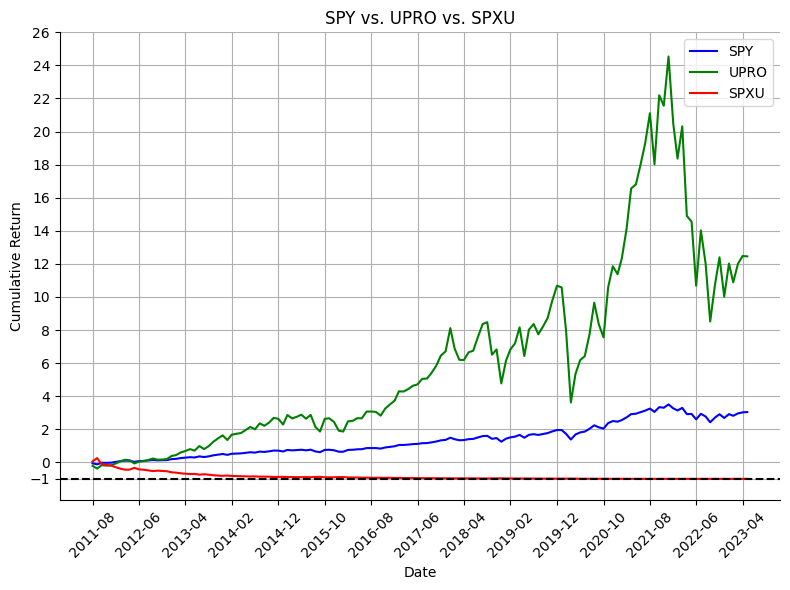

In [21]:
# Plot cumulative returns
spy_df = {
    "SPY": (1 + rets_spy["SPY US Equity"]).cumprod() - 1,
    "UPRO": (1 + rets_other["UPRO US Equity"]).cumprod() - 1,
    "SPXU": (1 + rets_other["SPXU US Equity"]).cumprod() - 1,
}

spy_df = pd.DataFrame(spy_df, index=rets_spy["SPY US Equity"].index)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(spy_df.index, spy_df["SPY"], label="SPY", color="blue")
ax.plot(spy_df.index, spy_df["UPRO"], label="UPRO", color="green")
ax.plot(spy_df.index, spy_df["SPXU"], label="SPXU", color="red")

ax.legend()
ax.grid(True)

ax.axhline(-1, color="black", linestyle="--")

ax.set_xticks(spy_df.index[::10])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in spy_df.index[::10]],
    rotation=45,
    horizontalalignment="center",
)
ax.set_title("SPY vs. UPRO vs. SPXU")
ax.set_yticks([-1] + [i for i in range(0, 27, 2)])
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Date")
fig.tight_layout()

-3x SPY decays to -100% returns pretty quickly.